In [1]:
import argparse
import os

import torch
import torchvision
import torch.optim as opt
import torchvision.transforms as trf

import matplotlib.pyplot as plt

from trainer import RunManager
from scheduler import LFADS_Scheduler
from objective import SVLAE_Loss, LFADS_Loss, LogLikelihoodPoisson, LogLikelihoodPoissonSimplePlusL1, LogLikelihoodPoissonSimple, LogLikelihoodGaussian
from svlae import SVLAE_Net, LFADS_Net
from utils import read_data, load_parameters
from plotter import Plotter
from utils import batchify_random_sample

In [2]:
hyperparameter_path = './hyperparameters/lorenz/svlae.yaml'
data_path = 'synth_data/lorenz_700'
output_dir = './models/'
batch_size = 65

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print(device)

hyperparams = load_parameters(hyperparameter_path)

orion_hp_string = ''
data_name = data_path.split('/')[-1]
model_name = hyperparams['model_name']
mhp_list = [key.replace('size', '').replace('deep', 'd').replace('obs', 'o').replace('_', '')[:4] + str(val) for key, val in hyperparams['model'].items() if 'size' in key]
mhp_list.sort()
hyperparams['run_name'] = '_'.join(mhp_list)
orion_hp_string = orion_hp_string.replace('\n', '-').replace(' ', '').replace('=', '')
orion_hp_string = '_orion-'+orion_hp_string
hyperparams['run_name'] += orion_hp_string
save_loc = '%s/%s/%s/%s/'%(output_dir, data_name, model_name, hyperparams['run_name'])

cuda


In [4]:
data_dict   = read_data(data_path)
train_data  = torch.Tensor(data_dict['train_fluor']).to(device)
valid_data  = torch.Tensor(data_dict['valid_fluor']).to(device)

num_trials, num_steps, input_size = train_data.shape

train_ds    = torch.utils.data.TensorDataset(train_data)
valid_ds    = torch.utils.data.TensorDataset(valid_data)
train_dl    = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle=True)
valid_dl    = torch.utils.data.DataLoader(valid_ds, batch_size = valid_data.shape[0])

In [5]:
hyperparams['model']['obs']['tau']['value']/=data_dict['dt']

model = SVLAE_Net(input_size            = input_size,
                  factor_size           = hyperparams['model']['factor_size'],
                  obs_encoder_size      = hyperparams['model']['obs_encoder_size'],
                  obs_latent_size       = hyperparams['model']['obs_latent_size'],
                  obs_controller_size   = hyperparams['model']['obs_controller_size'],
                  deep_g_encoder_size   = hyperparams['model']['deep_g_encoder_size'],
                  deep_c_encoder_size   = hyperparams['model']['deep_c_encoder_size'],
                  deep_g_latent_size    = hyperparams['model']['deep_g_latent_size'],
                  deep_u_latent_size    = hyperparams['model']['deep_u_latent_size'],
                  deep_controller_size  = hyperparams['model']['deep_controller_size'],
                  generator_size        = hyperparams['model']['generator_size'],
                  prior                 = hyperparams['model']['prior'],
                  clip_val              = hyperparams['model']['clip_val'],
                  generator_burn        = hyperparams['model']['generator_burn'],
                  dropout               = hyperparams['model']['dropout'],
                  do_normalize_factors  = hyperparams['model']['normalize_factors'],
                  factor_bias           = hyperparams['model']['factor_bias'],
                  max_norm              = hyperparams['model']['max_norm'],
                  deep_freeze           = hyperparams['model']['deep_freeze'],
                  deep_unfreeze_step    = hyperparams['model']['deep_unfreeze_step'],
                  obs_early_stop_step   = hyperparams['model']['obs_early_stop_step'],
                  obs_continue_step     = hyperparams['model']['obs_continue_step'],
                  obs_params            = hyperparams['model']['obs'],
                  device                = device).to(device)

In [6]:
loglikelihood_obs  = LogLikelihoodGaussian()
loglikelihood_deep = LogLikelihoodPoissonSimplePlusL1(dt=float(data_dict['dt']))

objective = SVLAE_Loss(loglikelihood_obs        = loglikelihood_obs,
                       loglikelihood_deep       = loglikelihood_deep,
                       loss_weight_dict         = {'kl_deep': hyperparams['objective']['kl_deep'],
                                                   'kl_obs' : hyperparams['objective']['kl_obs'],
                                                   'l2'     : hyperparams['objective']['l2']},
                       l2_con_scale             = hyperparams['objective']['l2_con_scale'],
                       l2_gen_scale             = hyperparams['objective']['l2_gen_scale']).to(device)

In [7]:
optimizer = opt.Adam([p for p in model.parameters() if p.requires_grad],
                     lr=hyperparams['optimizer']['lr_init'],
                     betas=hyperparams['optimizer']['betas'],
                     eps=hyperparams['optimizer']['eps'])

scheduler = LFADS_Scheduler(optimizer      = optimizer,
                            mode           = 'min',
                            factor         = hyperparams['scheduler']['scheduler_factor'],
                            patience       = hyperparams['scheduler']['scheduler_patience'],
                            verbose        = True,
                            threshold      = 1e-4,
                            threshold_mode = 'abs',
                            cooldown       = hyperparams['scheduler']['scheduler_cooldown'],
                            min_lr         = hyperparams['scheduler']['lr_min'])

TIME = torch._np.arange(0, num_steps*data_dict['dt'], data_dict['dt'])

plotter = {'train' : Plotter(time=TIME, truth={'rates'   : data_dict['train_rates'],
                                               'spikes'  : data_dict['train_spikes'],
                                               'latent'  : data_dict['train_latent']}),
           'valid' : Plotter(time=TIME, truth={'rates'   : data_dict['valid_rates'],
                                               'spikes'  : data_dict['valid_spikes'],
                                               'latent'  : data_dict['valid_latent']})}

In [8]:
transforms  = trf.Compose([])
run_manager = RunManager(model      = model,
                         objective  = objective,
                         optimizer  = optimizer,
                         scheduler  = scheduler,
                         train_dl   = train_dl,
                         valid_dl   = valid_dl,
                         transforms = transforms,
                         writer     = None,
                         plotter    = None,
                         max_epochs = 2000,
                         save_loc   = save_loc,
                         do_health_check = False)

In [9]:
model.obs_early_stop_step

32000

In [10]:
run_manager.load_checkpoint('recent')

19200
Unfreezing deep model parameters


In [14]:
torch.exp(0.5 * run_manager.model.obs_model.generator.calcium_generator.logvar)

tensor(0.4495, device='cuda:0', grad_fn=<ExpBackward>)

In [13]:
recon, factors = run_manager.model(valid_data)

In [15]:
-loglikelihood_obs(valid_data, recon['data'], run_manager.model.obs_model.generator.calcium_generator.logvar)

tensor(1907.7859, device='cuda:0', grad_fn=<NegBackward>)

In [16]:
-loglikelihood_deep(recon['spikes'].permute(1, 0, 2), recon['rates'].permute(1, 0, 2))

tensor(2099.7664, device='cuda:0', grad_fn=<NegBackward>)

In [17]:
-loglikelihood_deep(torch.Tensor(data_dict['valid_spikes']).to(device), recon['rates'].permute(1, 0, 2))

tensor(1543.3347, device='cuda:0', grad_fn=<NegBackward>)

In [18]:
-loglikelihood_deep(recon['spikes'].permute(1, 0, 2), torch.Tensor(data_dict['valid_rates']).to(device))

tensor(2191.4014, device='cuda:0', grad_fn=<NegBackward>)

In [19]:
-loglikelihood_deep(torch.Tensor(data_dict['valid_spikes']).to(device), torch.Tensor(data_dict['valid_rates']).to(device))

tensor(1456.1819, device='cuda:0')

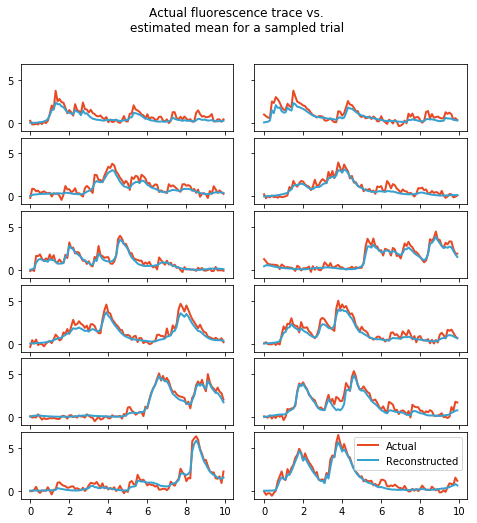

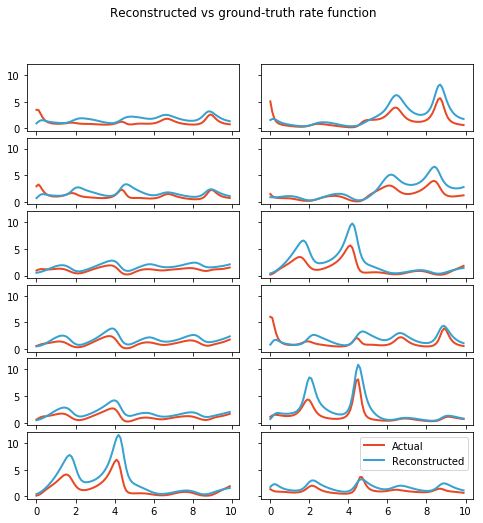

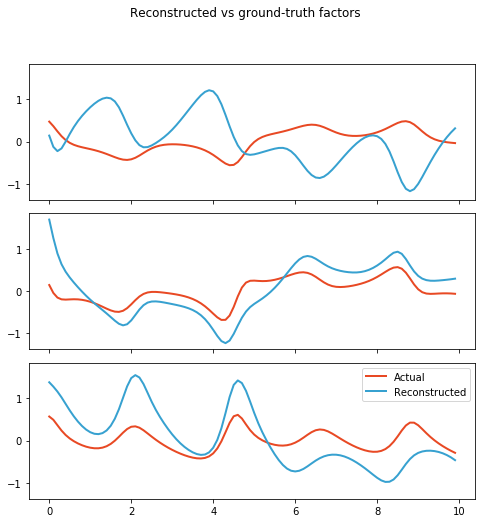

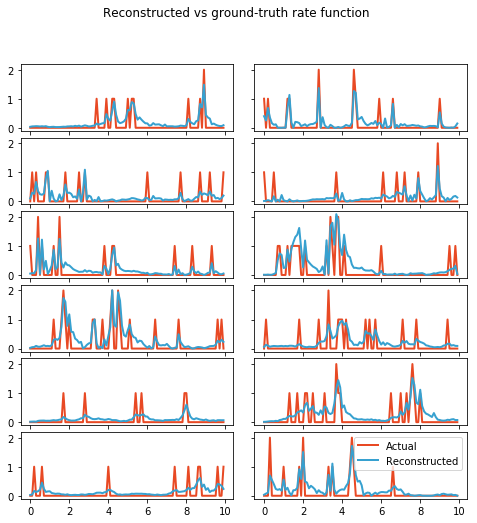

In [20]:
fig_dict = plotter['valid'].plot_summary(model = run_manager.model, dl=run_manager.valid_dl)

In [53]:
from matplotlib.figure import Figure
fig = fig_dict['truth_spikes']
fig.savefig()

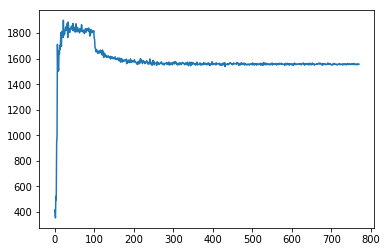

In [22]:
plt.plot(run_manager.loss_dict['valid']['recon_deep'])

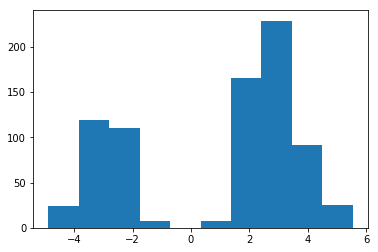

In [80]:
run_manager.model.train()
recon, (factors, inputs) = run_manager.model(valid_data.permute(1, 0, 2))
plt.hist(factors[0].detach().cpu().numpy().ravel());

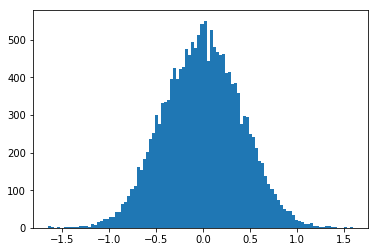

In [81]:
plt.hist(run_manager.model.deep_model.g_posterior_mean.detach().cpu().numpy().ravel(), bins=100);

In [82]:
g0 = run_manager.model.deep_model.sample_gaussian(run_manager.model.deep_model.g_posterior_mean, run_manager.model.deep_model.g_posterior_logvar)

In [83]:
gen_state0 = run_manager.model.deep_model.fc_genstate(g0)
gen_state1 = run_manager.model.deep_model.generator.gru_generator(None,gen_state0)
gen_state2 = run_manager.model.deep_model.generator.gru_generator(None,gen_state1)
gen_state3 = run_manager.model.deep_model.generator.gru_generator(None,gen_state2)
gen_state4 = run_manager.model.deep_model.generator.gru_generator(None,gen_state3)
gen_state5 = run_manager.model.deep_model.generator.gru_generator(None,gen_state4)
gen_state6 = run_manager.model.deep_model.generator.gru_generator(None,gen_state5)
gen_state7 = run_manager.model.deep_model.generator.gru_generator(None,gen_state6)
gen_state8 = run_manager.model.deep_model.generator.gru_generator(None,gen_state7)
gen_state9 = run_manager.model.deep_model.generator.gru_generator(None,gen_state8)
gen_state10 = run_manager.model.deep_model.generator.gru_generator(None,gen_state9)

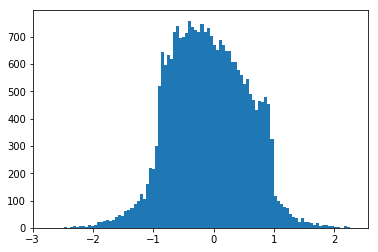

In [84]:
plt.hist(gen_state1.detach().cpu().numpy().ravel(), bins=100);

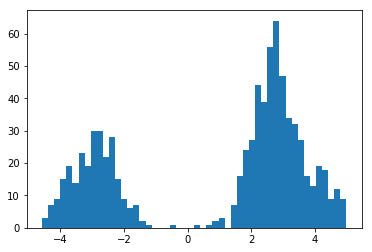

In [85]:
plt.hist(run_manager.model.deep_model.generator.fc_factors(gen_state1).detach().cpu().numpy().ravel(), bins=50);

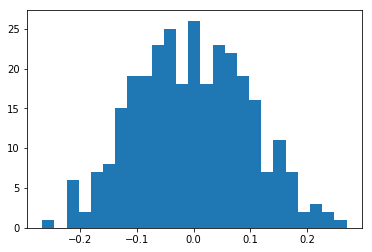

In [94]:
plt.hist(model.deep_model.generator.fc_factors.weight.data.detach().cpu().numpy().ravel(), bins=25);

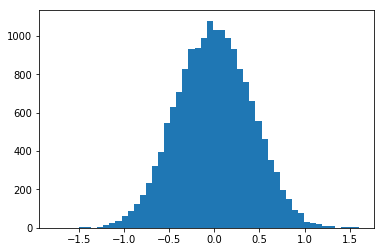

In [23]:
plt.hist(run_manager.model.deep_model.g_posterior_mean.detach().cpu().numpy().ravel(), bins=50);

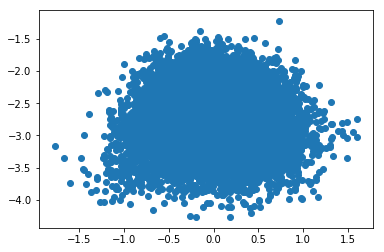

In [24]:
plt.scatter(run_manager.model.deep_model.g_posterior_mean.detach().cpu().numpy().ravel(), run_manager.model.deep_model.g_posterior_logvar.detach().cpu().numpy().ravel())

In [16]:
valid_plotter = plotter['valid']

{'ix': 76,
 'traces': <Figure size 576x576 with 12 Axes>,
 'truth_factors': <Figure size 576x576 with 3 Axes>,
 'truth_rates': <Figure size 576x576 with 12 Axes>,
 'truth_spikes': <Figure size 576x576 with 12 Axes>}

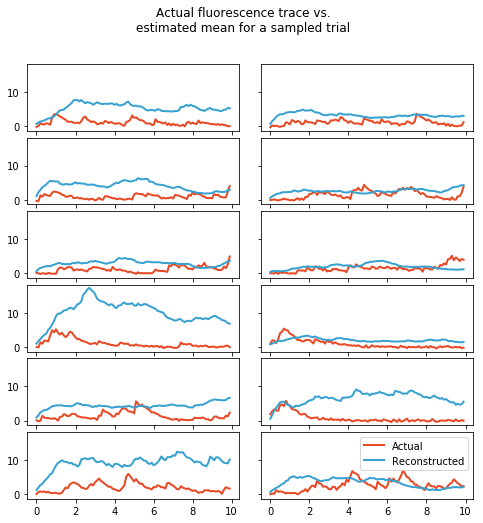

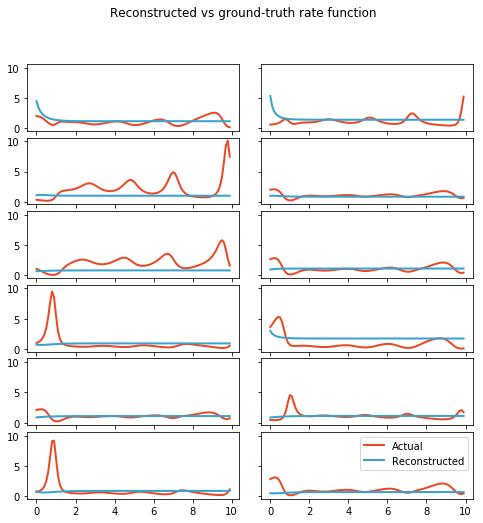

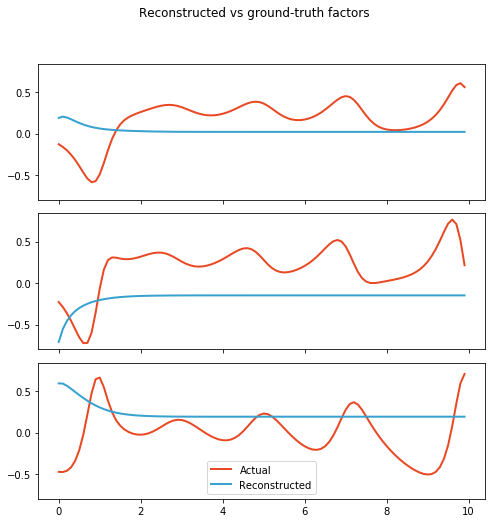

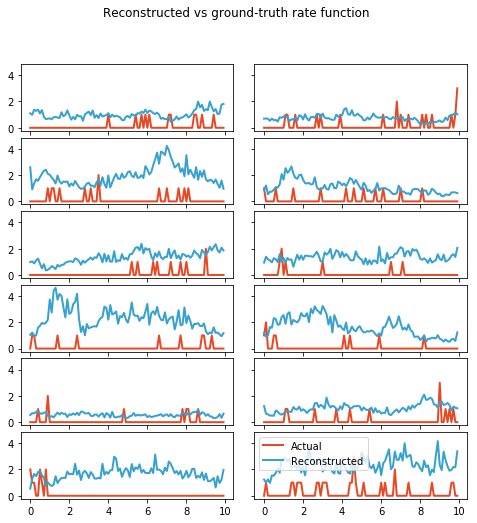

In [18]:
valid_plotter.plot_summary(model = run_manager.model, dl=run_manager.valid_dl)

In [21]:
run_manager.save_loc

'/home/luke/Documents/Projects/RichardsPostdoc/hierarchical_lfads/models/lorenz_700/svlae/alt/dcen0_dcon0_dgen64_dgla64_dula0_fact3_gene64_ocon128_oenc128_olat100_orion(lr=0.0100-kl_obs_dur=1600-kl_obs_max=1.000-kl_deep_max=1.000-deep_start=1600-l2_gen_scale=250.000-)'

In [27]:
hyperparameter_path = './hyperparameters/lorenz/lfads.yaml'
data_path = 'synth_data/lorenz_700'
output_dir = './models/'
batch_size = 65

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print(device)

hyperparams = load_parameters(hyperparameter_path)

data_name = data_path.split('/')[-1]
model_name = hyperparams['model_name']
mhp_list = [key.replace('size', '').replace('_', '')[:4] + str(val) for key, val in hyperparams['model'].items() if 'size' in key]
mhp_list.sort()
hyperparams['run_name'] = '_'.join(mhp_list) + '_retest'
save_loc = '%s/%s/%s/%s/'%(output_dir, data_name, model_name, hyperparams['run_name'])

cuda


In [29]:
data_dict   = read_data(data_path)
train_data  = torch.Tensor(data_dict['train_spikes']).to(device)
valid_data  = torch.Tensor(data_dict['valid_spikes']).to(device)

num_trials, num_steps, input_size = train_data.shape

train_ds    = torch.utils.data.TensorDataset(train_data)
valid_ds    = torch.utils.data.TensorDataset(valid_data)
train_dl    = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle=True)
valid_dl    = torch.utils.data.DataLoader(valid_ds, batch_size = valid_data.shape[0])

In [30]:
model = LFADS_Net(input_size           = input_size,
                  factor_size          = hyperparams['model']['factor_size'],
                  g_encoder_size       = hyperparams['model']['g_encoder_size'],
                  c_encoder_size       = hyperparams['model']['c_encoder_size'],
                  g_latent_size        = hyperparams['model']['g_latent_size'],
                  u_latent_size        = hyperparams['model']['u_latent_size'],
                  controller_size      = hyperparams['model']['c_controller_size'],
                  generator_size       = hyperparams['model']['generator_size'],
                  prior                = hyperparams['model']['prior'],
                  clip_val             = hyperparams['model']['clip_val'],
                  dropout              = hyperparams['model']['dropout'],
                  do_normalize_factors = hyperparams['model']['normalize_factors'],
                  max_norm             = hyperparams['model']['max_norm'],
                  device               = device).to(device)

In [31]:
loglikelihood = LogLikelihoodPoisson(dt=float(data_dict['dt']))

objective = LFADS_Loss(loglikelihood            = loglikelihood,
                       kl_weight_init           = hyperparams['objective']['kl_weight_init'],
                       kl_weight_schedule_dur   = hyperparams['objective']['kl_weight_schedule_dur'],
                       kl_weight_schedule_start = hyperparams['objective']['kl_weight_schedule_start'],
                       kl_weight_max            = hyperparams['objective']['kl_weight_max'],
                       l2_weight_init           = hyperparams['objective']['l2_weight_init'],
                       l2_weight_schedule_dur   = hyperparams['objective']['l2_weight_schedule_dur'],
                       l2_weight_schedule_start = hyperparams['objective']['l2_weight_schedule_start'],
                       l2_weight_max            = hyperparams['objective']['l2_weight_max'],
                       l2_con_scale             = hyperparams['objective']['l2_con_scale'],
                       l2_gen_scale             = hyperparams['objective']['l2_gen_scale']).to(device)

In [32]:
optimizer = opt.Adam([p for p in model.parameters() if p.requires_grad],
                     lr=hyperparams['optimizer']['lr_init'],
                     betas=hyperparams['optimizer']['betas'],
                     eps=hyperparams['optimizer']['eps'])

scheduler = LFADS_Scheduler(optimizer      = optimizer,
                            mode           = 'min',
                            factor         = hyperparams['scheduler']['scheduler_factor'],
                            patience       = hyperparams['scheduler']['scheduler_patience'],
                            verbose        = True,
                            threshold      = 1e-4,
                            threshold_mode = 'abs',
                            cooldown       = hyperparams['scheduler']['scheduler_cooldown'],
                            min_lr         = hyperparams['scheduler']['lr_min'])

TIME = torch._np.arange(0, num_steps*data_dict['dt'], data_dict['dt'])

plotter = {'train' : Plotter(time=TIME, truth={'rates'   : data_dict['train_rates'],
                                               'spikes'  : data_dict['train_spikes'],
                                               'latent'  : data_dict['train_latent']}),
           'valid' : Plotter(time=TIME, truth={'rates'   : data_dict['valid_rates'],
                                               'spikes'  : data_dict['valid_spikes'],
                                               'latent'  : data_dict['valid_latent']})}

In [33]:
run_manager = RunManager(model      = model,
                         objective  = objective,
                         optimizer  = optimizer,
                         scheduler  = scheduler,
                         train_dl   = train_dl,
                         valid_dl   = valid_dl,
                         writer     = None,
                         plotter    = None,
                         max_epochs = 2000,
                         save_loc   = save_loc,
                         do_health_check = False)

In [34]:
run_manager.load_checkpoint('best')

In [35]:
run_manager.epoch

267

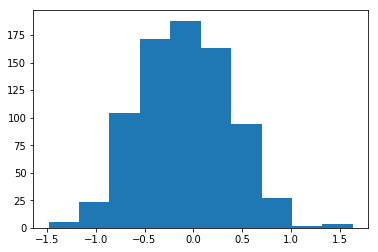

In [36]:
run_manager.model.train()
recon, (factors, inputs) = run_manager.model(valid_data.permute(1, 0, 2))
plt.hist(factors[0].detach().cpu().numpy().ravel());

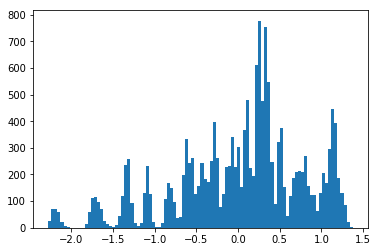

In [38]:
plt.hist(run_manager.model.g_posterior_mean.detach().cpu().numpy().ravel(), bins=100);

In [40]:
g0 = run_manager.model.sample_gaussian(run_manager.model.g_posterior_mean, run_manager.model.g_posterior_logvar)

In [42]:
gen_state0  = run_manager.model.fc_genstate(g0)
gen_state1  = run_manager.model.generator.gru_generator(None,gen_state0)
gen_state2  = run_manager.model.generator.gru_generator(None,gen_state1)
gen_state3  = run_manager.model.generator.gru_generator(None,gen_state2)
gen_state4  = run_manager.model.generator.gru_generator(None,gen_state3)
gen_state5  = run_manager.model.generator.gru_generator(None,gen_state4)
gen_state6  = run_manager.model.generator.gru_generator(None,gen_state5)
gen_state7  = run_manager.model.generator.gru_generator(None,gen_state6)
gen_state8  = run_manager.model.generator.gru_generator(None,gen_state7)
gen_state9  = run_manager.model.generator.gru_generator(None,gen_state8)
gen_state10 = run_manager.model.generator.gru_generator(None,gen_state9)

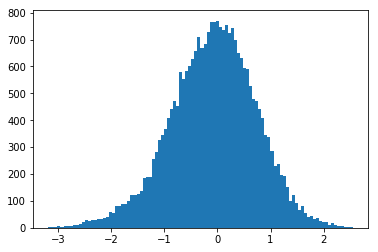

In [92]:
plt.hist(gen_state0.detach().cpu().numpy().ravel(), bins=100);

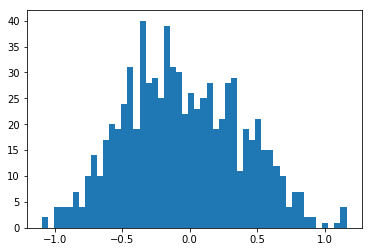

In [71]:
plt.hist(run_manager.model.generator.fc_factors(gen_state0).detach().cpu().numpy().ravel(), bins=50);

In [4]:
import argparse
import os
import pickle

import torch
import torchvision
import torchvision.transforms as trf
import torch.optim as opt

from trainer import RunManager
from scheduler import LFADS_Scheduler
from objective import LFADS_Loss, LogLikelihoodPoisson
from lfads import LFADS_MultiSession_Net
from utils import read_data, load_parameters
from plotter import Plotter
from dataset import LFADS_MultiSession_Dataset, SessionLoader

hyperparameter_path = './hyperparameters/brandon/lfads.yaml'
data_path = './data/mouse_2_brandon.pkl'
output_dir = './models/'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

hyperparams = load_parameters(hyperparameter_path)

# data_name = os.path.splitext(args.data_path.split('/')[-1])[0]
data_name = data_path.split('/')[-1]
model_name = hyperparams['model_name']
mhp_list = [key.replace('size', '').replace('_', '')[:4] + str(val) for key, val in hyperparams['model'].items() if 'size' in key]
mhp_list.sort()
hyperparams['run_name'] = '_'.join(mhp_list) + '_retest'
save_loc = '%s/%s/%s/%s/'%(output_dir, data_name, model_name, hyperparams['run_name'])

if not os.path.exists(save_loc):
    os.makedirs(save_loc)

data_dict   = pickle.load(open(data_path, 'rb'))
keys = [key for key in data_dict.keys() if type(key) is int]
keys.sort()
train_data_list  = [data_dict[key]['train'] for key in keys]
valid_data_list  = [data_dict[key]['valid'] for key in keys]


train_ds    = LFADS_MultiSession_Dataset(train_data_list, device=device)
valid_ds    = LFADS_MultiSession_Dataset(valid_data_list, device=device)
train_dl    = SessionLoader(train_ds, sampler=torch.utils.data.RandomSampler(train_ds))
valid_dl    = SessionLoader(valid_ds)

transforms  = trf.Compose([])

loglikelihood = LogLikelihoodPoisson(dt=float(data_dict['dt']))

objective = LFADS_Loss(loglikelihood            = loglikelihood,
                       loss_weight_dict         = {'kl': hyperparams['objective']['kl'], 
                                                   'l2': hyperparams['objective']['l2']},
                       l2_con_scale             = hyperparams['objective']['l2_con_scale'],
                       l2_gen_scale             = hyperparams['objective']['l2_gen_scale']).to(device)

W_in_list  = [torch.Tensor(data_dict[key]['W_in']).to(device) for key in keys]
W_out_list = [torch.Tensor(data_dict[key]['W_out']).to(device) for key in keys]
b_in_list  = [torch.Tensor(data_dict[key]['b_in']).to(device) for key in keys]
b_out_list = [torch.Tensor(data_dict[key]['b_out']).to(device) for key in keys]

model = LFADS_MultiSession_Net(W_in_list            = W_in_list,
                               W_out_list           = W_out_list,
                               b_in_list            = b_in_list,
                               b_out_list           = b_out_list,
                               factor_size          = hyperparams['model']['factor_size'],
                               g_encoder_size       = hyperparams['model']['g_encoder_size'],
                               c_encoder_size       = hyperparams['model']['c_encoder_size'],
                               g_latent_size        = hyperparams['model']['g_latent_size'],
                               u_latent_size        = hyperparams['model']['u_latent_size'],
                               controller_size      = hyperparams['model']['c_controller_size'],
                               generator_size       = hyperparams['model']['generator_size'],
                               prior                = hyperparams['model']['prior'],
                               clip_val             = hyperparams['model']['clip_val'],
                               dropout              = hyperparams['model']['dropout'],
                               do_normalize_factors = hyperparams['model']['normalize_factors'],
                               max_norm             = hyperparams['model']['max_norm'],
                               device               = device).to(device)

total_params = 0
for ix, (name, param) in enumerate(model.named_parameters()):
    print(ix, name, list(param.shape), param.numel(), param.requires_grad)
    total_params += param.numel()

print('Total parameters: %i'%total_params)

optimizer = opt.Adam(model.parameters(),
                     lr=hyperparams['optimizer']['lr_init'],
                     betas=hyperparams['optimizer']['betas'],
                     eps=hyperparams['optimizer']['eps'])

scheduler = LFADS_Scheduler(optimizer      = optimizer,
                            mode           = 'min',
                            factor         = hyperparams['scheduler']['scheduler_factor'],
                            patience       = hyperparams['scheduler']['scheduler_patience'],
                            verbose        = True,
                            threshold      = 1e-4,
                            threshold_mode = 'abs',
                            cooldown       = hyperparams['scheduler']['scheduler_cooldown'],
                            min_lr         = hyperparams['scheduler']['lr_min'])

num_steps = train_data_list[0].shape[1]
TIME = torch._np.arange(0, num_steps*data_dict['dt'], data_dict['dt'])

plotter = {'train' : Plotter(time=TIME),
           'valid' : Plotter(time=TIME)}

run_manager = RunManager(model      = model,
                         objective  = objective,
                         optimizer  = optimizer,
                         scheduler  = scheduler,
                         train_dl   = train_dl,
                         valid_dl   = valid_dl,
                         transforms = transforms,
                         writer     = None,
                         plotter    = None,
                         max_epochs = 2000,
                         save_loc   = save_loc,
                         do_health_check = False)

run_manager.load_checkpoint('recent')

0 g_encoder_init [2, 128] 256 True
1 g_prior_mean [128] 128 True
2 encoder.gru_g_encoder.weight_ih_l0 [384, 40] 15360 True
3 encoder.gru_g_encoder.weight_hh_l0 [384, 128] 49152 True
4 encoder.gru_g_encoder.bias_ih_l0 [384] 384 True
5 encoder.gru_g_encoder.bias_hh_l0 [384] 384 True
6 encoder.gru_g_encoder.weight_ih_l0_reverse [384, 40] 15360 True
7 encoder.gru_g_encoder.weight_hh_l0_reverse [384, 128] 49152 True
8 encoder.gru_g_encoder.bias_ih_l0_reverse [384] 384 True
9 encoder.gru_g_encoder.bias_hh_l0_reverse [384] 384 True
10 encoder.fc_g0_theta.weight [256, 256] 65536 True
11 encoder.fc_g0_theta.bias [256] 256 True
12 generator.gru_generator.fc_h_ru.weight [256, 128] 32768 True
13 generator.gru_generator.fc_h_ru.bias [256] 256 True
14 generator.gru_generator.fc_rh_c.weight [128, 128] 16384 True
15 generator.gru_generator.fc_rh_c.bias [128] 128 True
16 generator.fc_factors.weight [40, 128] 5120 True
17 fc_input_0.weight [40, 577] 23080 True
18 fc_input_0.bias [40] 40 True
19 fc_logra

In [7]:
import matplotlib.pyplot as plt

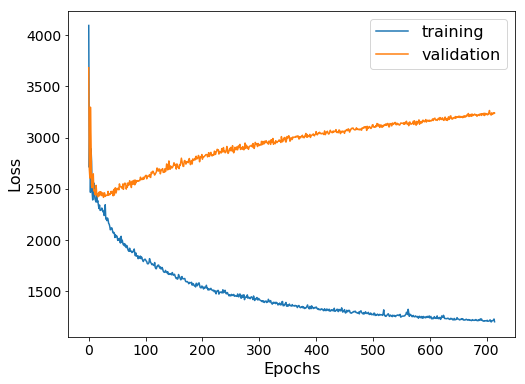

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(run_manager.loss_dict['train']['total'], label='training')
plt.plot(run_manager.loss_dict['valid']['total'], label='validation')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)